## In this notebook, a model is trained using a csv file that contains user marked spam and ham messages. Then it will take a custom user message to evaluate whether it is spam or ham.

### Importing libraries: Step 1

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

%matplotlib inline

In [83]:
sms = pd.read_csv('spam.csv',encoding='ISO-8859-1')
sms.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [84]:
sms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


### Data cleaning: remove unnecessary columns

In [85]:
sms.drop(labels= ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
sms.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Rename the columns and describe the dataframe

In [86]:
sms.rename(columns={'v1': 'label', 'v2': 'message'}, inplace=True)
sms.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [87]:
sms.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


### Make Word clouds of ham and spam messages by firstly creating a string of ham and spam respectively and then using WordCloud library.

In [88]:
ham_msg_text = ' '.join(sms[sms['label'] == 'ham']['message'])
spam_msg_text = ' '.join(sms[sms['label'] == 'spam']['message'])

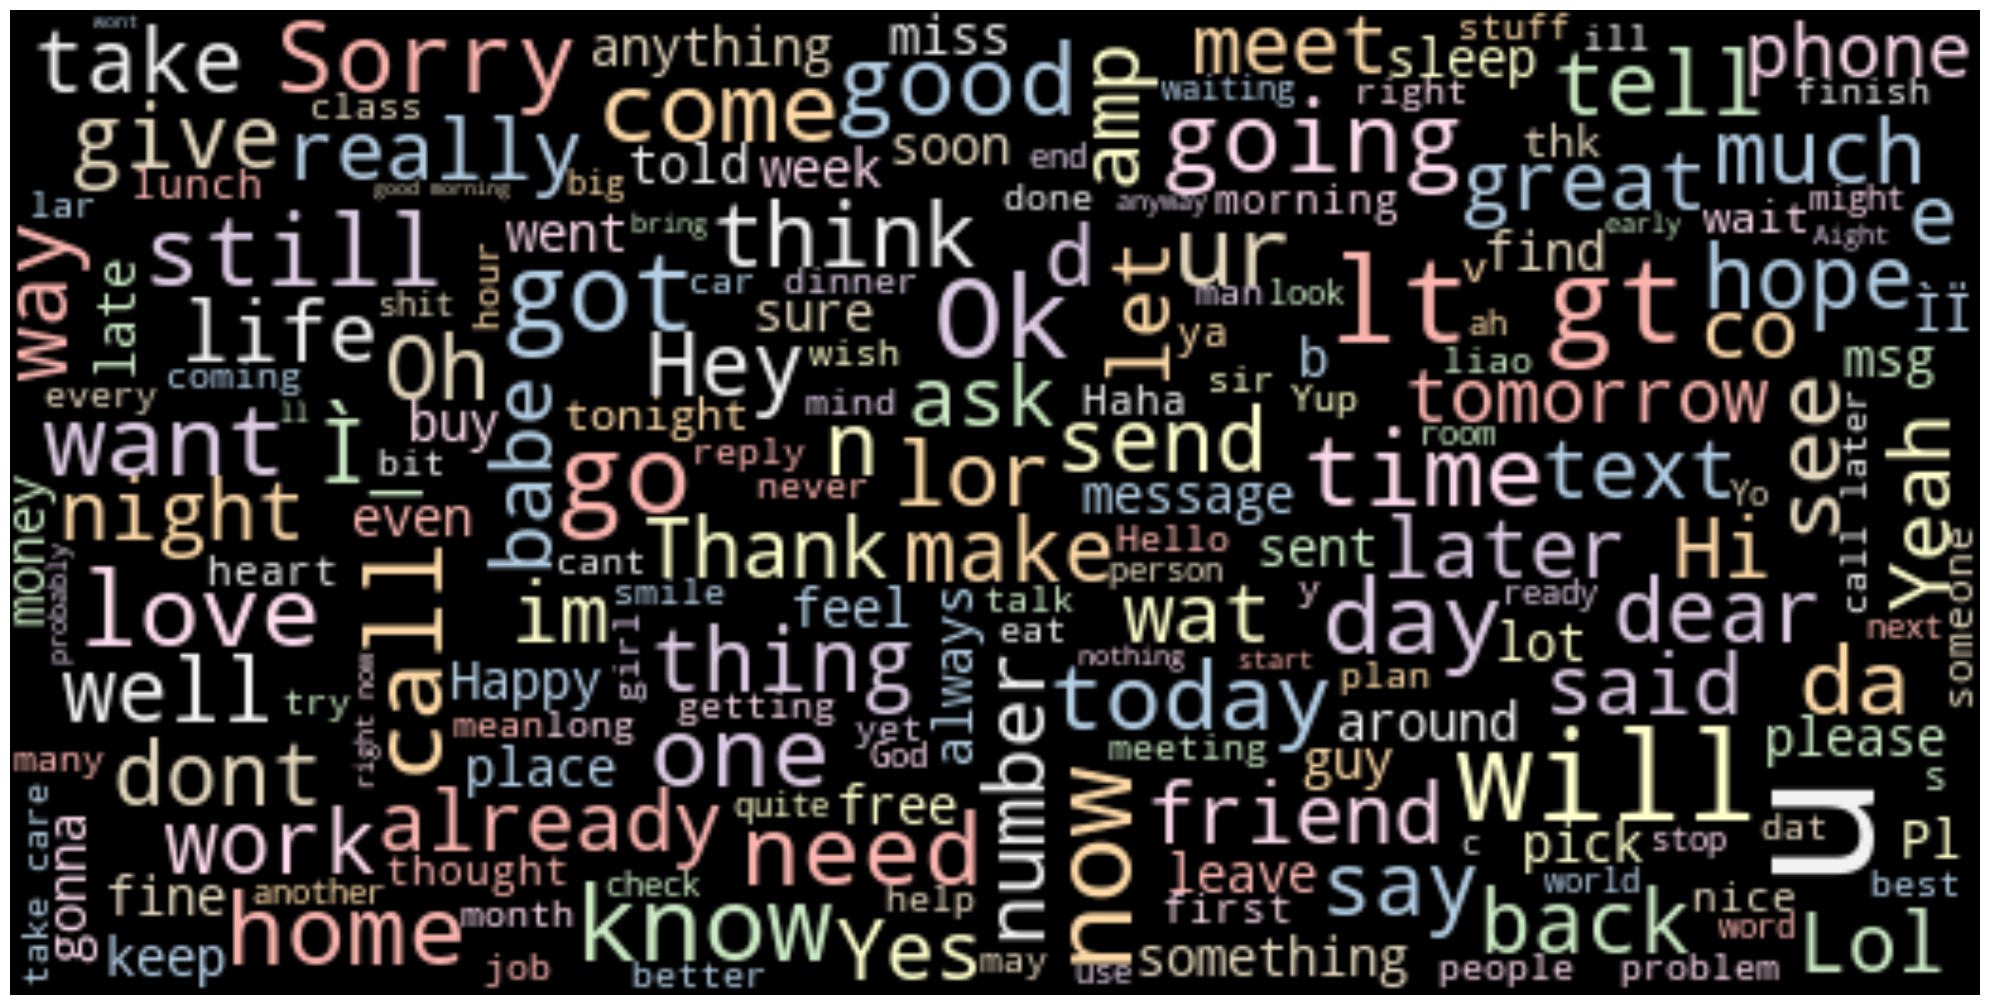

In [89]:
ham_msg_cloud = WordCloud(width =520,
                          height =260,
                          stopwords = STOPWORDS,
                          max_font_size = 50,
                          background_color = "black",
                          colormap = 'Pastel1').generate(ham_msg_text)
plt.figure(figsize=(20,14))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

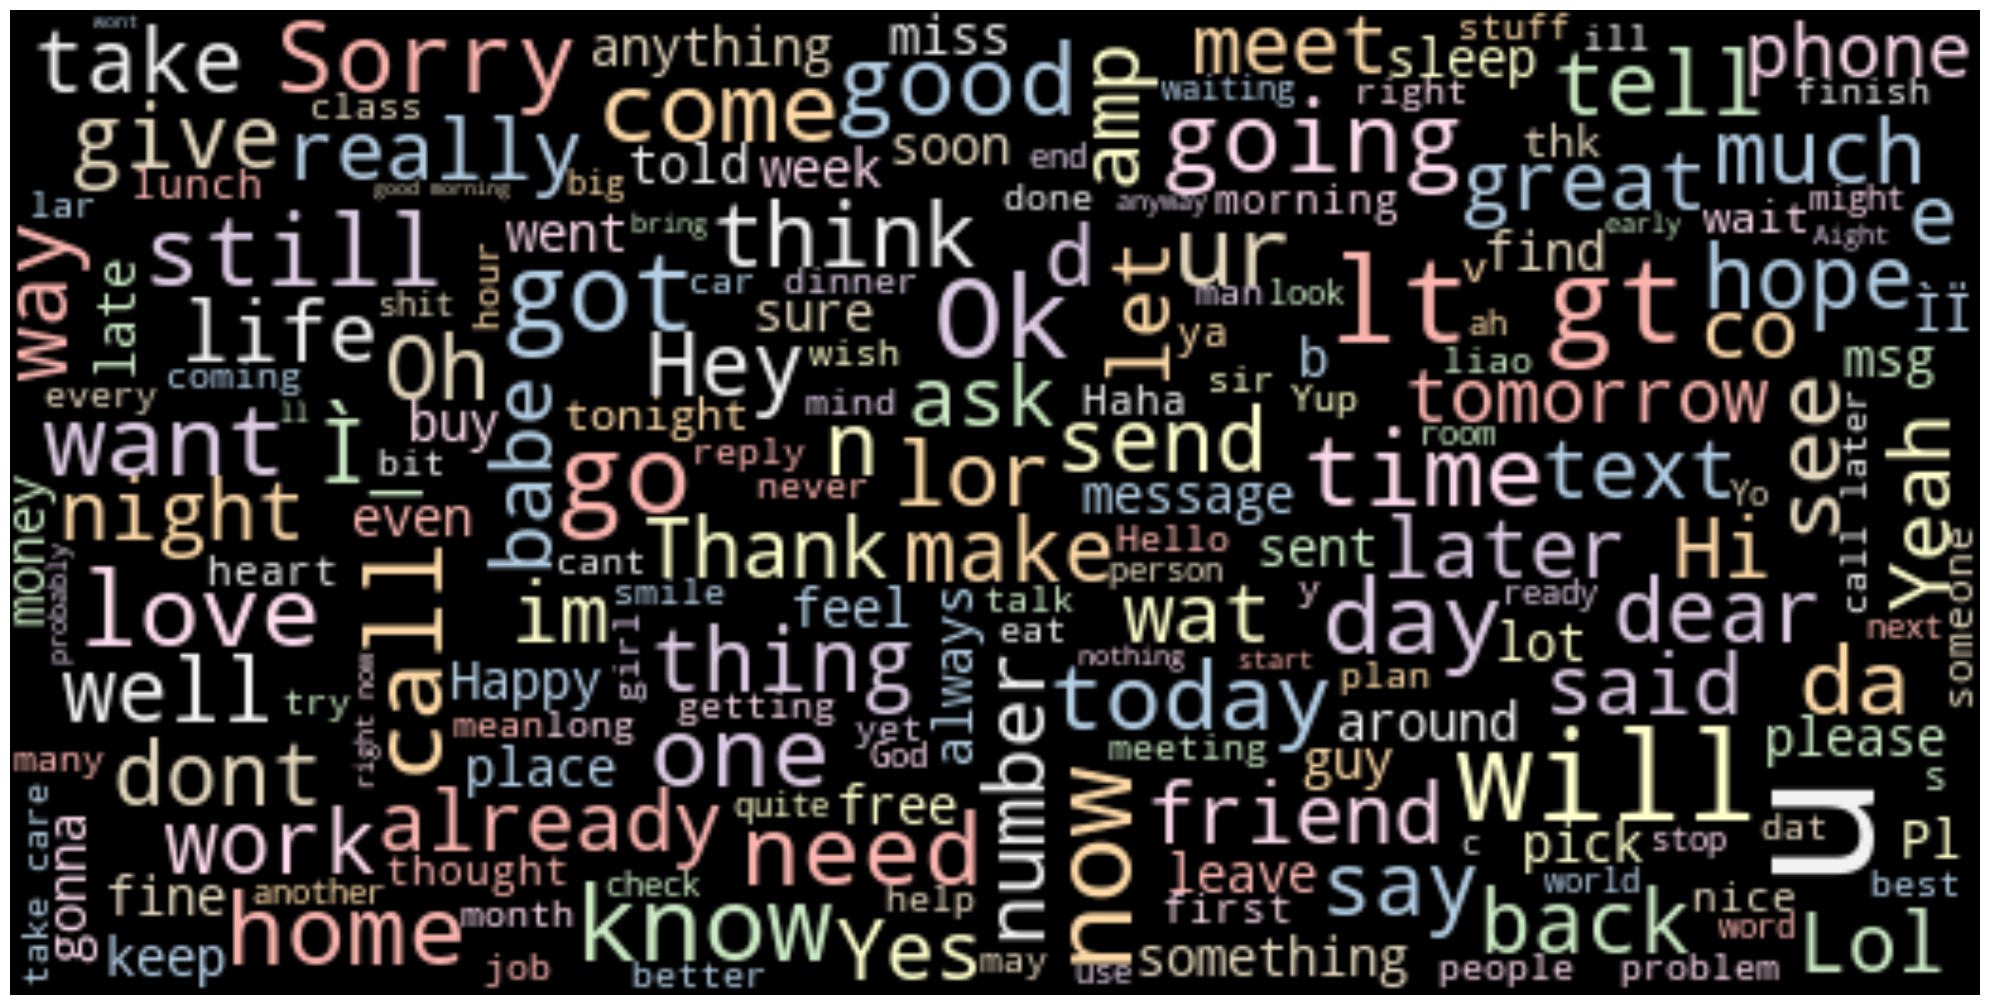

In [90]:
spam_msg_cloud = WordCloud(width =520,
                          height =260,
                          stopwords = STOPWORDS,
                          max_font_size = 50,
                          background_color = "black",
                          colormap = 'Pastel1').generate(spam_msg_text)
plt.figure(figsize=(20,14))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

C:\Users\lenovo\AppData\Local\Temp\ipykernel_13132\3830203958.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=sms, x='label', palette='pastel', saturation=1)


Text(0.5, 1.0, 'The message count distribution between ham and spam')

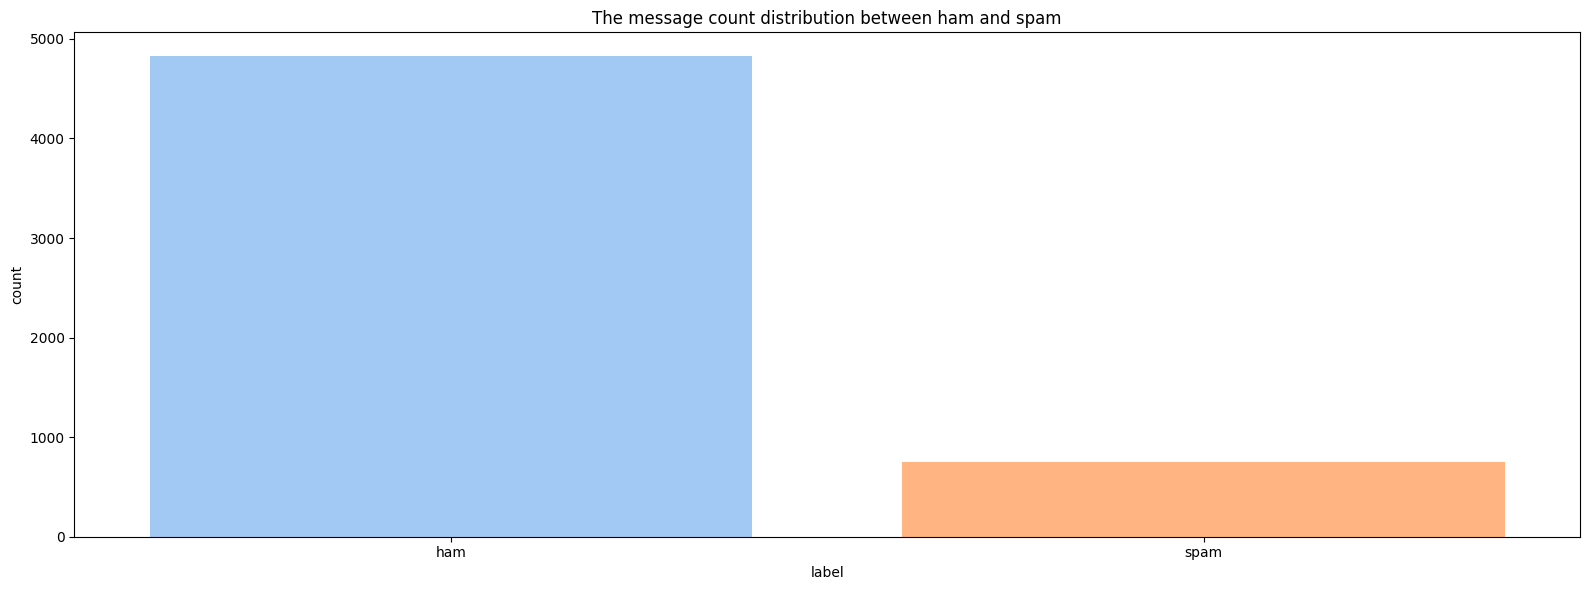

In [91]:
sns.countplot(data=sms, x='label', palette='pastel', saturation=1)
plt.title("The message count distribution between ham and spam")

In [92]:
print(f"Total number of ham enteries: {len(sms[sms['label'] == 'ham'])}")
print(f"Total number of spam enteries: {len(sms[sms['label'] == 'spam'])}")

Total number of ham enteries: 4825
Total number of spam enteries: 747


In [93]:
sms_ham = sms[sms['label'] == 'ham']
sms_spam = sms[sms['label'] == 'spam']
sms_ham_downsampled = sms_ham.sample(n = len(sms_spam), random_state = 44)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_13132\976308352.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=pd.concat([sms_ham_downsampled, sms_spam]), x='label', palette='pastel', saturation=1)


Text(0.5, 1.0, 'The message count distribution between ham and spam after ham downsampling')

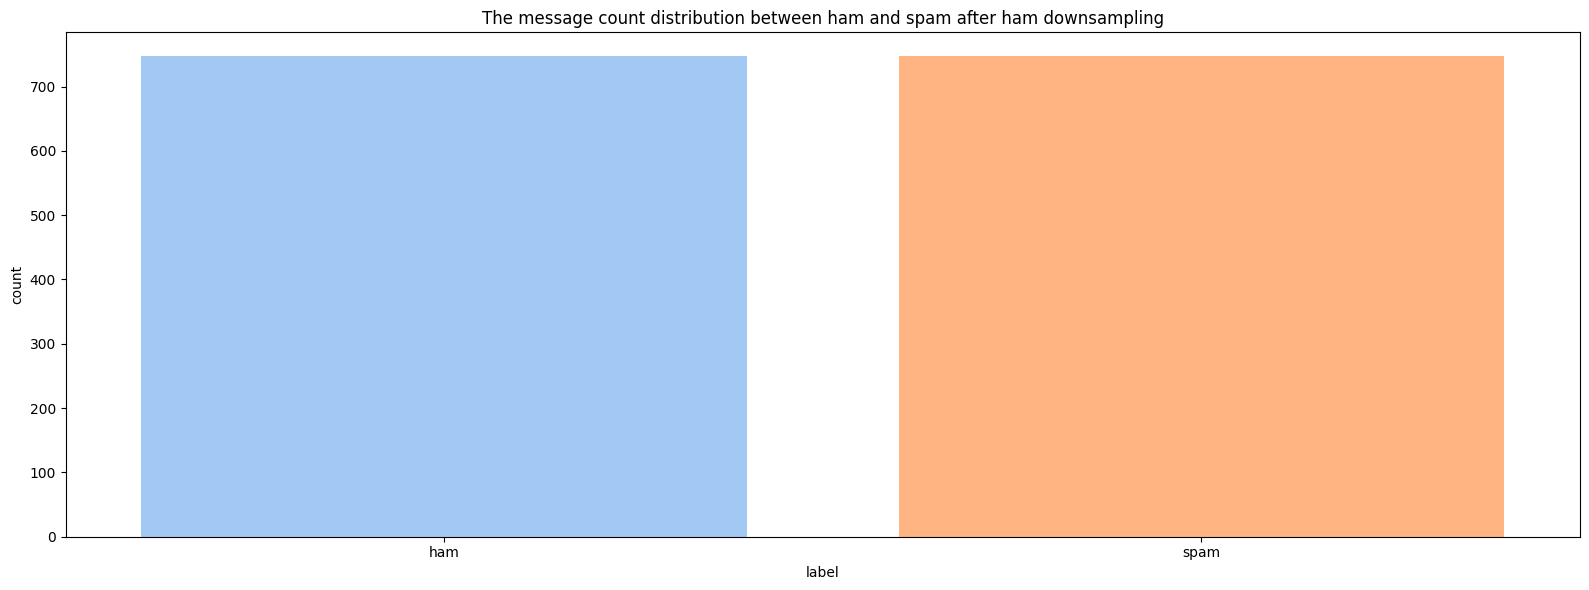

In [94]:
sns.countplot(data=pd.concat([sms_ham_downsampled, sms_spam]), x='label', palette='pastel', saturation=1)
plt.title("The message count distribution between ham and spam after ham downsampling")

In [95]:
# Dataframe for feeding into text preprocessing after downsampling of ham dataset.
sms_downsampled = pd.concat([sms_ham_downsampled, sms_spam])
sms_downsampled.head()

,label,message
3234,ham,"Yes, princess. Toledo."
3804,ham,Dude while were makin those weirdy brownies my...
2701,ham,"Hiya, sorry didn't hav signal. I haven't seen ..."
2822,ham,Then u ask darren go n pick u lor... But i oso...
5161,ham,Lol no. I just need to cash in my nitros. Hurr...


### Textual Preprocessing

### Importing libraries: Step 2

In [96]:
# Text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

#### a. Make two columns one indicating text length of a message and the next indicating the label type (0 for ham and 1 for spam)

In [97]:
# sms_downsampled["message"].iloc[0:2].apply(len)
# sms_downsampled['label'].iloc[:5].map({"ham": 0, "spam": 1})
sms_downsampled["sms_length"] = sms_downsampled["message"].apply(len)
sms_downsampled["sms_type"] = sms_downsampled["label"].map({"ham": 0, "spam": 1})
sms_downsampled.head()

,label,message,sms_length,sms_type
3234,ham,"Yes, princess. Toledo.",22,0
3804,ham,Dude while were makin those weirdy brownies my...,88,0
2701,ham,"Hiya, sorry didn't hav signal. I haven't seen ...",169,0
2822,ham,Then u ask darren go n pick u lor... But i oso...,74,0
5161,ham,Lol no. I just need to cash in my nitros. Hurr...,75,0


#### b. Perform train test split. A common practice is to split 80% data for training and 20% for testing. 

In [98]:
X_train, X_test, y_train, y_test = train_test_split(sms_downsampled["message"], sms_downsampled["sms_type"], test_size = 0.2, random_state = 434)

#### c. Tokenization

In [99]:
# Defining pre-processing parameters

# max_len: Maximum length of text that would be considered.
# trunc_type: truncating type. There are two types: pre and post. If a text is longer than max_length, it gets truncated either from start or from the end as for pre and post respectively.
# padding_type: Again two types of padding: pre and post. It means the text tensor is padded with a word if its length is less than max_length. In the training and testing tensors, words are replaced with numbers.
# oov_token: given to those words that are not in the vocab_size of 500 words.
# vocab_size: Maximum different words that would be considered to form a corpus. vocab_size -1 words are kept

max_len = 50 
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>' # out of vocabulary token
vocab_size = 500    # 500 most frequent qords are chosen

In [100]:
tokenizer = Tokenizer(num_words = vocab_size, 
                      char_level = False,
                      oov_token = oov_tok)
tokenizer.fit_on_texts(X_train)

In [101]:
word_index = tokenizer.word_index
total_words = len(word_index)
print(f"Total number of words: {total_words}")

Total number of words: 4054


#### d. Sequence & Padding

In [102]:
# For training data
training_sequences = tokenizer.texts_to_sequences(X_train)      # the messages are converted from text to numbers and are of unequal length
training_padded = pad_sequences(training_sequences,             # the messages are converted from text to numbers and are of equal length, which is max_len variable here
                                maxlen = max_len,
                                padding = padding_type,
                                truncating = trunc_type)

# For testing data
testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences,
                                maxlen = max_len,
                                padding = padding_type,
                                truncating = trunc_type)

### Model Architecture

### Importing Libraries: Step 3

In [103]:
# Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Dense

### a. Dense Architecture

In [104]:
# Define parameters
vocab_size = 500 
embedding_dim = 16
drop_value = 0.2
n_dense = 24

# Define Dense Model Architecture
model1 = Sequential()
model1.add(Embedding(vocab_size,
                    embedding_dim,
                    input_length = max_len))
model1.add(GlobalAveragePooling1D())
model1.add(Dense(24, activation='relu'))
model1.add(Dropout(drop_value))
model1.add(Dense(1, activation='sigmoid'))

In [105]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 50, 16)            8000      
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_3 (Dense)             (None, 24)                408       
                                                                 
 dropout_2 (Dropout)         (None, 24)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 25        
                                                                 
Total params: 8,433
Trainable params: 8,433
Non-trainable params: 0
____________________________________________________

#### Model Compilation

In [106]:
model1.compile(loss = 'binary_crossentropy', optimizer = 'adam' , metrics = ['accuracy'])

#### Model Training

In [107]:
num_epochs = 40
early_stop = EarlyStopping(monitor='val_loss', patience=4)
history1 = model1.fit(training_padded,
                    y_train,
                    epochs=num_epochs, 
                    validation_data=(testing_padded, y_test),
                    callbacks =[early_stop],
                    verbose=2)

Epoch 1/40
38/38 - 2s - loss: 0.6846 - accuracy: 0.5213 - val_loss: 0.6748 - val_accuracy: 0.6455 - 2s/epoch - 48ms/step
Epoch 2/40
38/38 - 0s - loss: 0.6602 - accuracy: 0.7874 - val_loss: 0.6436 - val_accuracy: 0.7926 - 476ms/epoch - 13ms/step
Epoch 3/40
38/38 - 1s - loss: 0.6146 - accuracy: 0.8485 - val_loss: 0.5867 - val_accuracy: 0.8462 - 580ms/epoch - 15ms/step
Epoch 4/40
38/38 - 0s - loss: 0.5406 - accuracy: 0.8762 - val_loss: 0.5094 - val_accuracy: 0.8662 - 486ms/epoch - 13ms/step
Epoch 5/40
38/38 - 1s - loss: 0.4573 - accuracy: 0.8912 - val_loss: 0.4299 - val_accuracy: 0.8729 - 588ms/epoch - 15ms/step
Epoch 6/40
38/38 - 1s - loss: 0.3825 - accuracy: 0.8937 - val_loss: 0.3627 - val_accuracy: 0.8863 - 522ms/epoch - 14ms/step
Epoch 7/40
38/38 - 1s - loss: 0.3144 - accuracy: 0.9079 - val_loss: 0.3103 - val_accuracy: 0.8963 - 507ms/epoch - 13ms/step
Epoch 8/40
38/38 - 1s - loss: 0.2668 - accuracy: 0.9155 - val_loss: 0.2686 - val_accuracy: 0.9064 - 567ms/epoch - 15ms/step
Epoch 9/40


#### Model Evaluation

In [108]:
model1.evaluate(testing_padded, y_test)

10/10 [==============================] - 0s 5ms/step - loss: 0.0874 - accuracy: 0.9632


[0.0873660072684288, 0.9632107019424438]

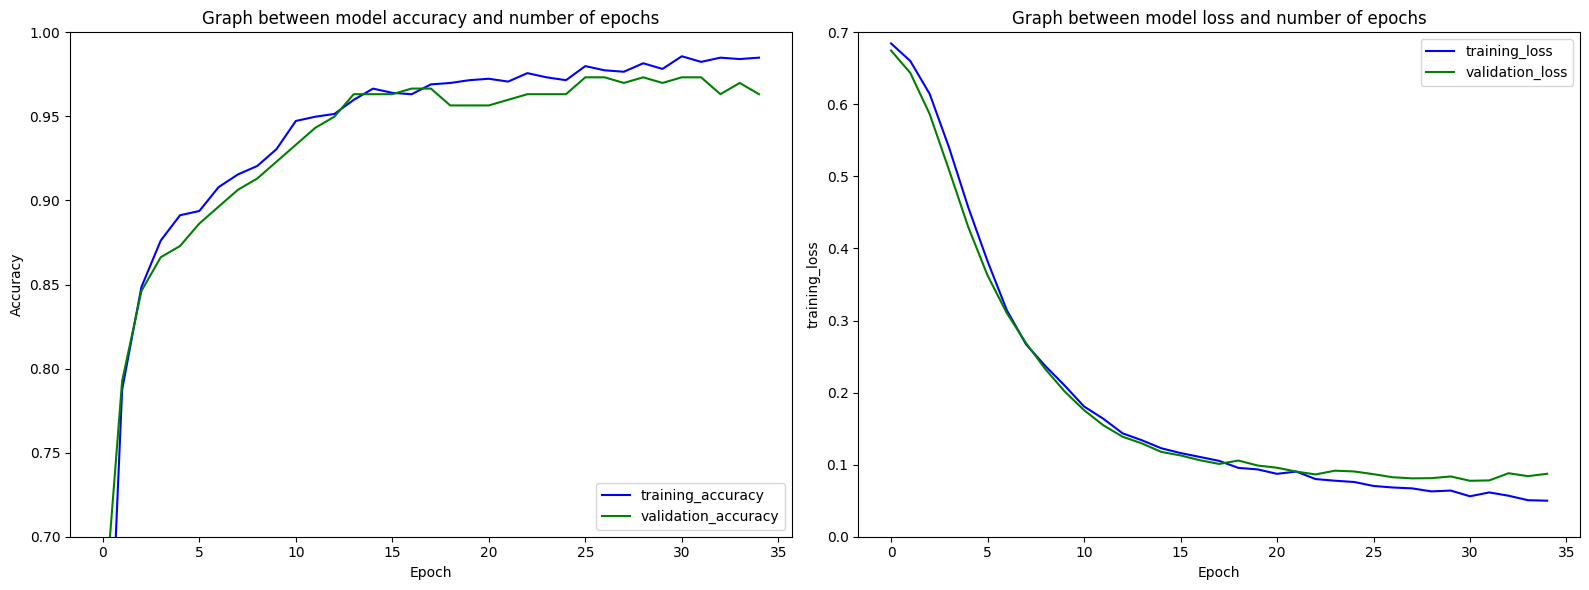

In [109]:
plt.rcParams["figure.figsize"] = [16,6]
plt.rcParams["figure.autolayout"] = True

ax1 = plt.subplot(1,2,1)
ax1.plot(history1.history['accuracy'], label='training_accuracy', color='b')
ax1.plot(history1.history['val_accuracy'], label='validation_accuracy', color='g')
ax1.set_title("Graph between model accuracy and number of epochs")
ax1.set_ylim(0.7, 1)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc="lower right")

ax2 = plt.subplot(1,2,2)
ax2.plot(history1.history['loss'], label='training_loss', color='b')
ax2.plot(history1.history['val_loss'], label='validation_loss', color='g')
ax2.set_title("Graph between model loss and number of epochs")
ax2.set_ylim(0, 0.7)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('training_loss')
ax2.legend(loc="upper right")

plt.show()

### b. LSTM

In [110]:
# Define parameters
n_lstm = 128
drop_lstm = 0.2

# Define LSTM Model 
model2 = Sequential()
model2.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model2.add(SpatialDropout1D(drop_lstm))
model2.add(LSTM(n_lstm, return_sequences=False))
model2.add(Dropout(drop_lstm))
model2.add(Dense(1, activation='sigmoid'))

In [111]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 16)            8000      
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 50, 16)           0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 128)               74240     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 82,369
Trainable params: 82,369
Non-trainable params: 0
__________________________________________________

#### Model Compilation

In [112]:
model2.compile(loss = 'binary_crossentropy', optimizer = 'adam' , metrics = ['accuracy'])

#### Model Training

In [113]:
num_epochs = 40
early_stop = EarlyStopping(monitor='val_loss', patience=4)
history2 = model2.fit(training_padded,
                    y_train,
                    epochs=num_epochs, 
                    validation_data=(testing_padded, y_test),
                    callbacks =[early_stop],
                    verbose=2)

Epoch 1/40


38/38 - 3s - loss: 0.6705 - accuracy: 0.5515 - val_loss: 0.6350 - val_accuracy: 0.6388 - 3s/epoch - 75ms/step
Epoch 2/40
38/38 - 1s - loss: 0.3708 - accuracy: 0.8711 - val_loss: 0.3278 - val_accuracy: 0.8896 - 536ms/epoch - 14ms/step
Epoch 3/40
38/38 - 0s - loss: 0.2257 - accuracy: 0.9280 - val_loss: 0.1362 - val_accuracy: 0.9532 - 480ms/epoch - 13ms/step
Epoch 4/40
38/38 - 0s - loss: 0.1522 - accuracy: 0.9523 - val_loss: 0.0942 - val_accuracy: 0.9632 - 469ms/epoch - 12ms/step
Epoch 5/40
38/38 - 0s - loss: 0.1098 - accuracy: 0.9665 - val_loss: 0.1368 - val_accuracy: 0.9666 - 464ms/epoch - 12ms/step
Epoch 6/40
38/38 - 0s - loss: 0.1024 - accuracy: 0.9699 - val_loss: 0.1095 - val_accuracy: 0.9632 - 458ms/epoch - 12ms/step
Epoch 7/40
38/38 - 0s - loss: 0.0770 - accuracy: 0.9782 - val_loss: 0.0694 - val_accuracy: 0.9766 - 463ms/epoch - 12ms/step
Epoch 8/40
38/38 - 0s - loss: 0.0683 - accuracy: 0.9808 - val_loss: 0.0935 - val_accuracy: 0.9732 - 459ms/epoch - 12ms/step
Epoch 9/40
38/38 - 0s 

#### Model Evaluation

In [114]:
model2.evaluate(testing_padded, y_test)

10/10 [==============================] - 0s 6ms/step - loss: 0.1706 - accuracy: 0.9632


[0.17063336074352264, 0.9632107019424438]

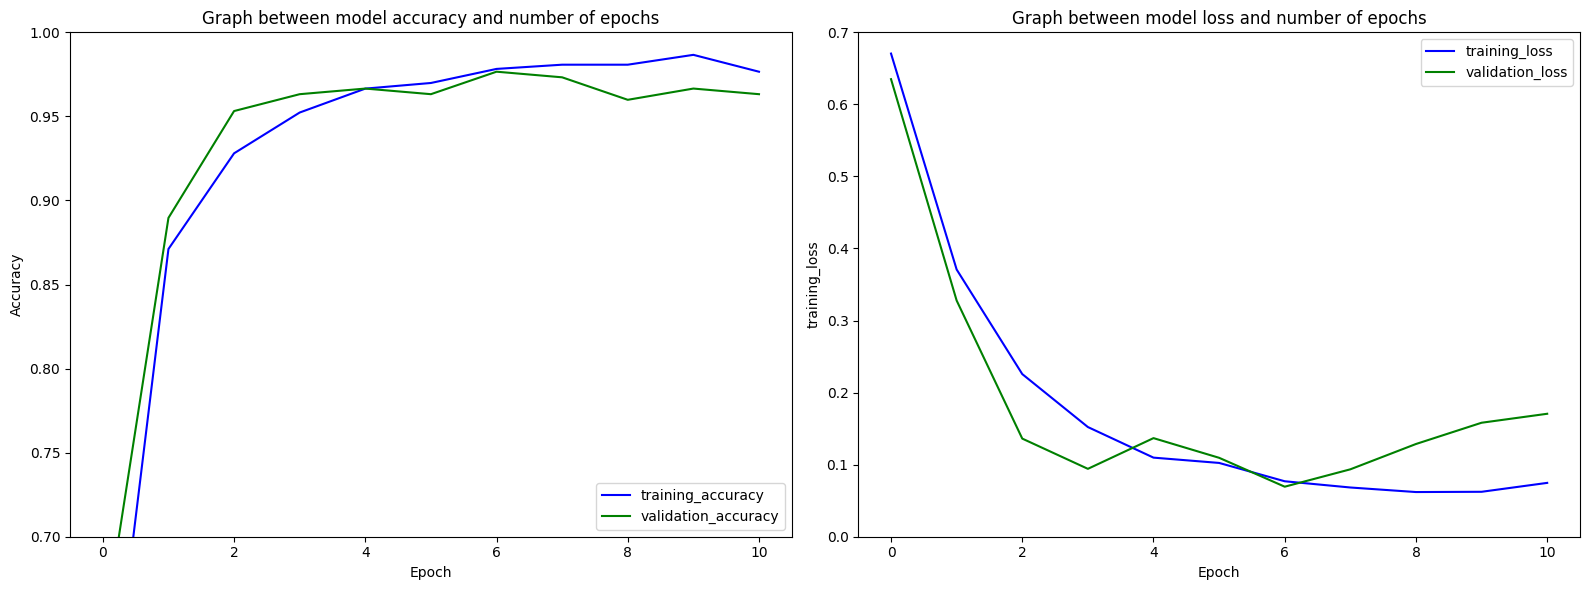

In [115]:
plt.rcParams["figure.figsize"] = [16,6]
plt.rcParams["figure.autolayout"] = True

ax1 = plt.subplot(1,2,1)
ax1.plot(history2.history['accuracy'], label='training_accuracy', color='b')
ax1.plot(history2.history['val_accuracy'], label='validation_accuracy', color='g')
ax1.set_title("Graph between model accuracy and number of epochs")
ax1.set_ylim(0.7, 1)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc="lower right")

ax2 = plt.subplot(1,2,2)
ax2.plot(history2.history['loss'], label='training_loss', color='b')
ax2.plot(history2.history['val_loss'], label='validation_loss', color='g')
ax2.set_title("Graph between model loss and number of epochs")
ax2.set_ylim(0, 0.7)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('training_loss')
ax2.legend(loc="upper right")

### Prediction

In [116]:
sms

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


#### Predictions from Dense model

In [117]:
# Function to convert text to numbers for the input to the model
def predict_spam(predict_msg):
  new_seq = tokenizer.texts_to_sequences(predict_msg)
  padded = pad_sequences(new_seq,
                         maxlen = max_len,
                         padding = padding_type,
                         truncating = trunc_type)
  return(model1.predict(padded))

In [118]:
while True:
    num = int(input("Enter a random number between 0 and 5571 (inclusive): "))
    if num == 5572:
        break
    predict_msg = [sms['message'].iloc[num]]
    predict_spam(predict_msg).shape
    print(f"The percentage of the message being spam from the Dense model: {np.round(predict_spam(predict_msg)[0][0] * 100, 2)}%.")
    print(f"Actual label from the dataframe: {sms['label'].iloc[num]}")

1/1 [==============================] - 0s 24ms/step
The percentage of the message being spam from the Dense model: 0.85%.
Actual label from the dataframe: ham
1/1 [==============================] - 0s 48ms/step
The percentage of the message being spam from the Dense model: 12.9%.
Actual label from the dataframe: ham
1/1 [==============================] - 0s 46ms/step
The percentage of the message being spam from the Dense model: 0.48%.
Actual label from the dataframe: ham


#### Predictions from LSTM

In [119]:
# Function to convert text to numbers for the input to the LSTM model
def predict_spam(predict_msg):
  new_seq = tokenizer.texts_to_sequences(predict_msg)
  padded = pad_sequences(new_seq,
                         maxlen = max_len,
                         padding = padding_type,
                         truncating = trunc_type)
  return(model2.predict(padded))

In [120]:
while True:
    num = int(input("Enter a random number between 0 and 5571 (inclusive): "))
    if num == 5572:
        break
    predict_msg = [sms['message'].iloc[num]]
    predict_spam(predict_msg).shape
    print(f"The percentage of the message being spam from the LSTM model: {np.round(predict_spam(predict_msg)[0][0] * 100, 2)}%.")
    print(f"Actual label from the dataframe: {sms['label'].iloc[num]}")

1/1 [==============================] - 0s 36ms/step
The percentage of the message being spam from the LSTM model: 56.45%.
Actual label from the dataframe: ham
1/1 [==============================] - 0s 28ms/step
The percentage of the message being spam from the LSTM model: 3.33%.
Actual label from the dataframe: ham
1/1 [==============================] - 0s 34ms/step
The percentage of the message being spam from the LSTM model: 99.96%.
Actual label from the dataframe: spam
1/1 [==============================] - 0s 22ms/step
The percentage of the message being spam from the LSTM model: 97.68%.
Actual label from the dataframe: ham
1/1 [==============================] - 0s 22ms/step
The percentage of the message being spam from the LSTM model: 2.45%.
Actual label from the dataframe: ham
1/1 [==============================] - 0s 31ms/step
The percentage of the message being spam from the LSTM model: 7.59%.
Actual label from the dataframe: ham
